In [1]:
pname = 'stokes'
n_params = 7

# NB: order training meshes by largest first
train_mesh_names = ['reference_mesh.csv', 'reference_mesh_small.csv', 'reference_mesh_tiny.csv']
train_solution_names = ['matrix.mat', 'matrix_small.mat', 'matrix_tiny.mat']

test_mesh_names = ['reference_mesh_large.csv', 'reference_mesh.csv', 'reference_mesh_small.csv', 'reference_mesh_tiny.csv']
test_solution_names = ['matrix_large.mat', 'matrix.mat', 'matrix_small.mat', 'matrix_tiny.mat']

save_name = 'best_model_sm.pt'

In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pykdtree.kdtree import KDTree
import math
import random

In [3]:
seed=10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

## THE MODEL

In [4]:
class GFN_AE(nn.Module):
    """
    Module implementing the GFN method for the encoder and decoder architectures.
    Methods:
    __init__: initialises the master mesh, and master weight & biases for the 1st and last layer of the encoder and decoder, respectively
    expand: add all new expansive nodes in the new mesh to the weight matrices
    agglomerate: agglomerate nodes to fit the new mesh
    encoder: execute the encoder part
    decoder: execute the decoder part
    """
    def __init__(self, mesh_m, latent_size=20):
        super().__init__()
        size = mesh_m.shape[0]
        self.latent_size = latent_size
        self.We_m = nn.Parameter(torch.empty(size, self.latent_size))
        self.be_m = nn.Parameter(torch.empty(self.latent_size))
        self.Wd_m = nn.Parameter(torch.empty(self.latent_size, size))
        self.bd_m = nn.Parameter(torch.empty(size))
        self.mesh_m = mesh_m
        
        self.initialise(self.We_m, self.be_m)
        self.initialise(self.Wd_m, self.bd_m)
        
        # Note: no self.be_n since we never need to reshape the encoder biases i.e. be_n == be_m in all cases
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        self.mesh_n = self.mesh_m
        
    def initialise(self, weight, bias):
        stdv = 1. / math.sqrt(weight.size(1))
        weight.data.uniform_(-stdv, stdv)
        bias.data.uniform_(-stdv, stdv)

    def expand(self, mesh_n, kd_tree_m=None, kd_tree_n=None, nn_m=None, nn_n=None, **kwargs):
        """
        Expand the new weights and biases with the new expansive nodes. If during training, update the master weights, biases & mesh.
        If during inference, then just apply the new ones.
        """
        
        # During evaluation, we will have fixed mesh_m so we don't want to recompute every time => option to pass in
        if nn_n is not None:
            pass
        elif kd_tree_n is not None:
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        else:
            kd_tree_m = KDTree(self.mesh_m)
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        # During training, we will have fixed fidelities that we know and don't need to always recompute
        if nn_m is not None:
            pass
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]

        if not self.training:
            # ! testing mode !
            
            # could assign with .data calls here but can't do for train https://discuss.pytorch.org/t/function-tbackward-returned-an-invalid-gradient-at-index-0-got-1-3-but-expected-shape-compatible-with-1-2/125259
            
            count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
            nodes_added = 0 # how much did we increase our master mesh

            for pt_n, pt_m in enumerate(nn_n):
                if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                    nodes_added += 1
                    self.mesh_n = np.vstack([self.mesh_n, mesh_n[pt_n]])
                    count_m[pt_m]+=1

                    # Divide encoder weights by number of expansions
                    self.We_n[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                    # Store the index of the weight we want
                    # so we can update at the end without storing
                    # all the nodes to update explictly
                    new_row = torch.zeros(1, self.We_n.shape[1])
                    new_row[0][0] = pt_m
                    self.We_n = torch.cat((self.We_n, new_row), dim=0)

                    # Duplicate weights for decoder
                    self.Wd_n = torch.cat((self.Wd_n, self.Wd_n[:, pt_m:pt_m+1]), dim=1)
                    self.bd_n = torch.cat([self.bd_n, self.bd_n[pt_m:pt_m+1]])

            # Loop over the nodes we need to update using the index we stored in the first element
            for i in range(self.mesh_m.shape[0], self.mesh_m.shape[0]+nodes_added):
                index = int(self.We_n[i,0])
                self.We_n[i] = self.We_n[index]
        else:
            # ! training mode !
            
            # Expansion step is essentially creating new weights from scratch
            # => ignore gradients and therefore allow for slicing on leaf tensor as required
            # (Unless we do something smarter with the gradient tree to track what we're doing...)
            with torch.no_grad():
                count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
                nodes_added = 0 # how much did we increase our master mesh
                size=self.mesh_m.shape[0]

                for pt_n, pt_m in enumerate(nn_n):
                    if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                        nodes_added += 1
                        self.mesh_m=np.vstack([self.mesh_m, mesh_n[pt_n]])
                        count_m[pt_m]+=1
                        
                        # Divide encoder weights by number of expansions
                        self.We_m[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                        # Store the index of the weight we want
                        # so we can update at the end without storing
                        # all the nodes to update explictly
                        new_row = torch.zeros(1, self.We_m.shape[1])
                        new_row[0][0] = pt_m
                        self.We_m = nn.Parameter(torch.cat((self.We_m, new_row), dim=0))
                        
                        # Duplicate weights for decoder
                        self.Wd_m = nn.Parameter(torch.cat((self.Wd_m, self.Wd_m[:, pt_m:pt_m+1]), dim=1))
                        self.bd_m = nn.Parameter(torch.cat([self.bd_m, self.bd_m[pt_m:pt_m+1]]))
                
                # Loop over the nodes we need to update using the index we stored in the first element
                for i in range(size, size+nodes_added):
                    index = int(self.We_m[i,0])
                    self.We_m[i] = self.We_m[index]
            
            # now we need to track gradients from our new master weights
            self.We_n = self.We_m.clone()
            self.Wd_n = self.Wd_m.clone()
            self.bd_n = self.bd_m.clone()
        return nodes_added
        
    def agglomerate(self, mesh_n, kd_tree_n=None, nn_m=None, **kwargs):
        
        # known during training
        if nn_m is not None:
            pass
        # already found in expansion or already known during training
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]

        # FIND NEW WEIGHTS (AGGLOMERATIVE ONLY NOW)
        We_n = torch.zeros((mesh_n.shape[0], self.We_n.shape[1]), device=self.We_n.device)
        Wd_n = torch.zeros((self.We_n.shape[1], mesh_n.shape[0]), device=self.We_n.device)
        bd_n = torch.zeros(mesh_n.shape[0], device=self.We_n.device)

        count_n = np.zeros(mesh_n.shape[0])

        for m, pt_m in enumerate(self.mesh_n): # agglomerate
            nn_n = nn_m[m]
            count_n[nn_n]+=1
            We_n[nn_n] += self.We_n[m]
            Wd_n[:, nn_n] = ( (count_n[nn_n]-1)*Wd_n[:, nn_n] + self.Wd_n[:, m] )/count_n[nn_n]
            bd_n[nn_n] = ( (count_n[nn_n]-1)*bd_n[nn_n] + self.bd_n[m] )/count_n[nn_n]
          
        self.We_n = We_n
        self.Wd_n = Wd_n
        self.bd_n = bd_n
        
    def reset(self):
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        if not self.training:
            self.mesh_n = self.mesh_m
        
    def encoder(self, x, mesh_n, exp_enc=True, agg_enc=True, reset_enc=False, **kwargs):
        if reset_enc:
            self.reset()
        if exp_enc:
            self.expand(mesh_n, **kwargs)
        if agg_enc:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.We_n+self.be_m
        
    def decoder(self, x, mesh_n, exp_dec=True, agg_dec=True, reset_dec=False, **kwargs):
        if reset_dec:
            self.reset()
        if exp_dec:
            self.expand(mesh_n, **kwargs)
        if agg_dec:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.Wd_n+self.bd_n
    
class GCA(nn.Module):
    
    def __init__(self, mesh_m, gfn_latent_size=20, latent_size=20, n_params=7, act=nn.Tanh, ae_sizes=[], map_sizes=[50]*4):
        super().__init__()
        self.GFN = GFN_AE(mesh_m, gfn_latent_size)
        
        self.act = act()
        
        module_list_enc = []
        module_list_dec = []

        for i in range(len(ae_sizes)):
            module_list_dec.append(self.act)
            if i==0:
                module_list_enc.append(nn.Linear(gfn_latent_size, ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], gfn_latent_size))
            else:
                module_list_enc.append(nn.Linear(ae_sizes[i-1], ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], ae_sizes[i-1]))
            module_list_enc.append(self.act)
        if len(ae_sizes)!=0:
            module_list_dec.append(self.act)
            module_list_enc.append(nn.Linear(ae_sizes[-1], latent_size))
            module_list_dec.append(nn.Linear(latent_size, ae_sizes[-1]))
            module_list_enc.append(self.act)
        
        self.encoder = nn.Sequential(*module_list_enc)
        self.decoder = nn.Sequential(*module_list_dec[::-1])
        
        module_list_map = []
        
        for i in range(len(map_sizes)):
            if i==0:
                module_list_map.append(nn.Linear(n_params, map_sizes[i]))
            else:
                module_list_map.append(nn.Linear(map_sizes[i-1], map_sizes[i]))
            module_list_map.append(act())
        if len(map_sizes)!=0:
            module_list_map.append(nn.Linear(map_sizes[-1], latent_size))
            
        self.mapper = nn.Sequential(*module_list_map)
        
    def forward(self, x, mesh_n, params, **kwargs):
        x_enc = self.act(self.GFN.encoder(x, mesh_n, **kwargs))
        x_enc = self.encoder(x_enc)
        
        x_map = self.mapper(params)
        
        x_recon = self.decoder(x_enc)
        x_recon = self.GFN.decoder(x_enc, mesh_n, **kwargs)
        
        return x_recon, x_enc, x_map

## SET UP TRAINING DATA

In [5]:
from itertools import product
import scipy
from sklearn import preprocessing

def get_params(pname='stokes'):
    if pname=='stokes':
        mu_range = [(0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (-np.pi/6,np.pi/6), (-10,10)]
        mus = []
        n_pts = [2]*(len(mu_range)-1)+[11]
        for i in range(len(mu_range)):
            mus.append(np.linspace(mu_range[i][0], mu_range[i][1], n_pts[i]))
        return torch.tensor(np.array(list(product(*mus)))).float()
    elif pname=='graetz':
        mus = [np.linspace(1., 3., 10), np.linspace(0.01, 0.1, 20)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T).float()
    elif pname=='advection':
        mus = [np.linspace(0., 6., 10), np.linspace(-1.0, 1.0, 10)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T).float()

def scaler_func():
    return preprocessing.StandardScaler()

def scaling(U):
    scaling_fun_1 = scaler_func()
    scaling_fun_2 = scaler_func()
    scaler_s = scaling_fun_1.fit(U)
    temp = torch.t(torch.tensor(scaler_s.transform(U)))
    scaler_f = scaling_fun_2.fit(temp)
    scaled_data = torch.unsqueeze(torch.t(torch.tensor(scaler_f.transform(temp))),0).permute(2, 1, 0)
    scale = [scaler_s, scaler_f]
    return scale, scaled_data[:,:,0]

def undo_scaling(U, scale):
    scaler_s = scale[0]
    scaler_f = scale[1]
    rescaled_data = torch.tensor(scaler_s.inverse_transform(torch.t(torch.tensor(scaler_f.inverse_transform(U.detach().numpy().squeeze())))))
    return rescaled_data

def get_scaled_data(fname):
    U_orig = torch.tensor(scipy.io.loadmat(fname)['U'])
    scale, U_sc = scaling(U_orig)
    print('reconstruction error', ((U_orig - undo_scaling(U_sc, scale))**2).sum())
    return scale, U_sc

In [6]:
params = get_params(pname).to(dev)

dfs_train = [pd.read_csv(i, header=None).values for i in train_mesh_names]

sols_train = [get_scaled_data(i)[1].float().to(dev) for i in train_solution_names]

trajs = list(range(sols_train[0].shape[0]))
random.shuffle(trajs)
train_trajs, test_trajs = np.array_split(trajs, 2)
train_trajs = np.array_split(train_trajs, len(dfs_train))

# train_trajs = random.sample(range(704), 352)
# test_trajs =list(set(range(704))-set(train_trajs))
# train_trajs=[train_trajs[176:], train_trajs[:176]]

reconstruction error tensor(4.0544e-27, dtype=torch.float64)
reconstruction error tensor(1.0720e-27, dtype=torch.float64)
reconstruction error tensor(2.1232e-28, dtype=torch.float64)


## TRAIN THE MODEL

In [7]:
# initialisation
# NB - important to start with largest mesh since this is better for initialisation purposes
# and potential savings in no expansions are done
model = GCA(dfs_train[0]).to(dev)

# conduct the expansion step
added_nodes = 0
for df in dfs_train[1:]:
    added_nodes += model.GFN.expand(df)

added_nodes

0

In [8]:
from tqdm import tqdm

In [9]:
model.train()

# now initialise our optimiser after we have conducted ALL expansions
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

In [10]:
best_loss = np.inf
EPOCHS = 5#000
test_losses = []
train_losses = []

def criterion(x, x_recon, x_enc, x_map):
    return nn.functional.mse_loss(x, x_recon)+1e1*nn.functional.mse_loss(x_enc, x_map)

kd_tree_m = KDTree(model.GFN.mesh_m)
# we know ahead of time the nn_n and nn_ms since we know that the master mesh is never changing and our new meshes are fixed
nn_ns = [kd_tree_m.query(df, k=1)[1] for df in dfs_train]
nn_ms = [KDTree(df).query(model.GFN.mesh_m, k=1)[1] for df in dfs_train]

for i in tqdm(range(EPOCHS)):
    opt.zero_grad()

    U_train = sols_train[0][train_trajs[0]]
    params_train = params[train_trajs[0]]
    df_train = dfs_train[0]
    if added_nodes==0:
        # because added_nodes==0, we know we don't need to expand or agglom for the medium mesh
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
    else:
        # NEED TO TEST
        # we need to agglomerate because added_nodes>0. However, we do this all in the encoder first so we can avoid in the decoder
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_n=nn_ns[0], nn_m=nn_ms[0])

    loss = criterion(U_train, x_recon, x_enc, x_map)*df_train.shape[0]

    # other fidelities
    for j in range(1, len(dfs_train)):
        U_train = sols_train[j][train_trajs[j]]
        params_train = params[train_trajs[j]]
        df_train = dfs_train[j]
        
        # only need to agglom in training since we expanded as a preprocessing step
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_m=nn_ms[j], nn_n=nn_ns[j])
        loss += criterion(U_train, x_recon, x_enc, x_map)*df_train.shape[0]
    
    loss /= np.sum([k.shape[0] for k in dfs_train])
    loss.backward()
    opt.step()
    
    train_loss = loss.item()
    
    with torch.no_grad():
        params_test = params[test_trajs]
        
        U_test = sols_train[0][test_trajs]
        df_test = dfs_train[0]

        if added_nodes==0:
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
        else:
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_n=nn_ns[0], nn_m=nn_ms[0])
        test_loss = criterion(U_test, x_recon, x_enc, x_map).item()*df_test.shape[0]

        for j in range(1, len(dfs_train)):
            U_test = sols_train[j][test_trajs]
            df_test = dfs_train[j]
            
            # only need to agglom in training since we expanded as a preprocessing step
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_m=nn_ms[j], nn_n=nn_ns[j])
            test_loss += criterion(U_test, x_recon, x_enc, x_map).item()*df_train.shape[0]
        
        test_loss /= np.sum([k.shape[0] for k in dfs_train])
    
    print(f'Epoch {i}: train loss: {train_loss} | test loss: {test_loss}')
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if test_loss<best_loss:
        best_loss=test_loss
        best_epoch = i
        torch.save(model.state_dict(), save_name)

 20%|██        | 1/5 [00:04<00:18,  4.74s/it]

Epoch 0: train loss: 10.192414283752441 | test loss: 8.047617745411031


 40%|████      | 2/5 [00:09<00:13,  4.62s/it]

Epoch 1: train loss: 9.589112281799316 | test loss: 7.783030015776242


 60%|██████    | 3/5 [00:13<00:09,  4.55s/it]

Epoch 2: train loss: 9.294427871704102 | test loss: 7.5501771058726534


 80%|████████  | 4/5 [00:18<00:04,  4.52s/it]

Epoch 3: train loss: 8.957832336425781 | test loss: 7.22350989021379


100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

Epoch 4: train loss: 8.568116188049316 | test loss: 6.950985881234048


In [11]:
model = GCA(dfs_train[0]).to(dev)

# conduct the expansion step
added_nodes = 0
for df in dfs_train[1:]:
    added_nodes += model.GFN.expand(df)

model.load_state_dict(torch.load(save_name))

<All keys matched successfully>

## EVALUATE PERFORMANCE

In [12]:
def print_results(model, df_large, U_large, scale, params):
    
    with torch.no_grad():
        x_recon, x_enc, x_map = model(U_large, df_large, params, reset_enc=True, reset_dec=True)
        
        x_rom = model.decoder(x_map)
        x_rom = model.GFN.decoder(x_rom, df_large, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False)

        error_abs_list = list()
        norm_z_list = list()
        latents_error = list()
        Z = undo_scaling(U_large, scale)
        Z_net = undo_scaling(x_rom, scale)
        for snap in range(U_large.shape[0]):
            error_abs = np.linalg.norm(abs(Z[:, snap] - Z_net[:, snap]))
            norm_z = np.linalg.norm(Z[:, snap], 2)
            error_abs_list.append(error_abs)
            norm_z_list.append(norm_z)
            lat_err = np.linalg.norm(x_enc[snap] - x_map[snap])/np.linalg.norm(x_enc[snap])
            latents_error.append(lat_err)

        latents_error = np.array(latents_error)
        print("\nMaximum relative error for latent  = ", max(latents_error))
        print("Mean relative error for latent = ", sum(latents_error)/len(latents_error))
        print("Minimum relative error for latent = ", min(latents_error))

        error = np.array(error_abs_list)
        norm = np.array(norm_z_list)
        rel_error = error/norm
        print("\nMaximum absolute error for field "+" = ", max(error))
        print("Mean absolute error for field "+" = ", sum(error)/len(error))
        print("Minimum absolute error for field "+" = ", min(error))
        print("\nMaximum relative error for field "+" = ", max(rel_error))
        print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
        print("Minimum relative error for field "+" = ", min(rel_error))

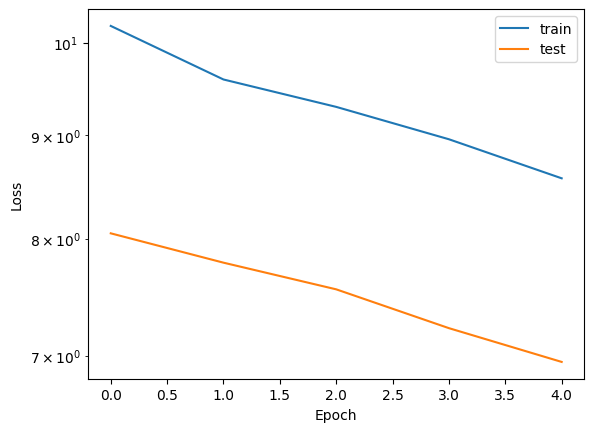

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
for i in range(len(test_mesh_names)):
    print(f'TEST MESH: {test_mesh_names[i]}')
    scale, U = get_scaled_data(test_solution_names[i])
    U = U.to('cpu').float()
    df = pd.read_csv(test_mesh_names[i], header=None).values

    model.eval()
    model.to('cpu')
    print_results(model, df, U, scale, params.to('cpu'))
    print()

TEST MESH: reference_mesh_large.csv
reconstruction error tensor(9.1108e-27, dtype=torch.float64)

Maximum relative error for latent  =  1.1272395
Mean relative error for latent =  0.9648970429023559
Minimum relative error for latent =  0.85728574

Maximum absolute error for field  =  67.13029841506109
Mean absolute error for field  =  28.22893037527601
Minimum absolute error for field  =  11.515028085327973

Maximum relative error for field  =  0.682847925537893
Mean relative error for field  =  0.3588289814043636
Minimum relative error for field  =  0.1671819125793226

TEST MESH: reference_mesh.csv
reconstruction error tensor(4.0544e-27, dtype=torch.float64)

Maximum relative error for latent  =  1.1216075
Mean relative error for latent =  0.9640367620370605
Minimum relative error for latent =  0.84948266

Maximum absolute error for field  =  44.5874582568028
Mean absolute error for field  =  18.756708627333712
Minimum absolute error for field  =  7.653587461644862

Maximum relative e